In [ ]:
# TODO: Instalar dependencias
!pip install -q ultralytics opencv-python matplotlib numpy pandas seaborn

# Imports
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import random
from google.colab import files
from IPython.display import Image, display

# Verificar instalación
import ultralytics
print(f"Ultralytics version: {ultralytics.__version__}")

# GPU check (recomendado para training)
import torch
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Usando CPU (fine-tuning será más lento)")

Ultralytics version: 8.3.226
CUDA disponible: True
GPU: Tesla T4


In [ ]:
# TODO: Cargar YOLOv8 nano pre-entrenado (COCO)
# Fill in the blank: ¿Qué modelo de YOLOv8 vamos a cargar?
model_base = YOLO('yolov8n.pt')  # Completa: 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt'

print("\n=== MODELO BASE (COCO) ===")
print(f"Clases en COCO: {len(model_base.names)}")
print(f"Ejemplos de clases: {list(model_base.names.values())[:20]}")

# Verificar clases relevantes para grocery
grocery_relevant = ['apple', 'orange', 'banana', 'carrot', 'bottle', 'cup', 'bowl']
print(f"\nClases 'grocery' en COCO: {grocery_relevant}")
print("⚠️ Nota: COCO tiene clases genéricas, no productos específicos")


=== MODELO BASE (COCO) ===
Clases en COCO: 80
Ejemplos de clases: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow']

Clases 'grocery' en COCO: ['apple', 'orange', 'banana', 'carrot', 'bottle', 'cup', 'bowl']
⚠️ Nota: COCO tiene clases genéricas, no productos específicos


- Se elige yolo8n por limitaciones del entorno de ejecucion.
- COCO tiene 80 clases, estas no son suficientes clases, ya que un supermercado maneja mas de 80 productos.


- el modelo aprendió el concepto abstracto de un objeto, no una instancia específica de marca o tipo.

- Por ejemplo si lo traspolamos a los autos, nosotros le eseñamos a identificar un auto, o sea el concepto, pero no diferencia entre un Ferrari o un Fiat, sigue siendo un auto. A nosotros nos sirve que identifique a cada vehiculo como es.

--2025-11-09 14:34:10--  https://images.unsplash.com/photo-1542838132-92c53300491e
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2258122 (2.2M) [image/jpeg]
Saving to: ‘grocery_aisle.jpg’

grocery_aisle.jpg   100%[===================>]   2.15M  --.-KB/s    in 0.02s   

2025-11-09 14:34:10 (110 MB/s) - ‘grocery_aisle.jpg’ saved [2258122/2258122]


=== INFERENCIA CON MODELO BASE ===

image 1/1 /content/grocery_aisle.jpg: 480x640 3 oranges, 49.7ms
Speed: 3.0ms preprocess, 49.7ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


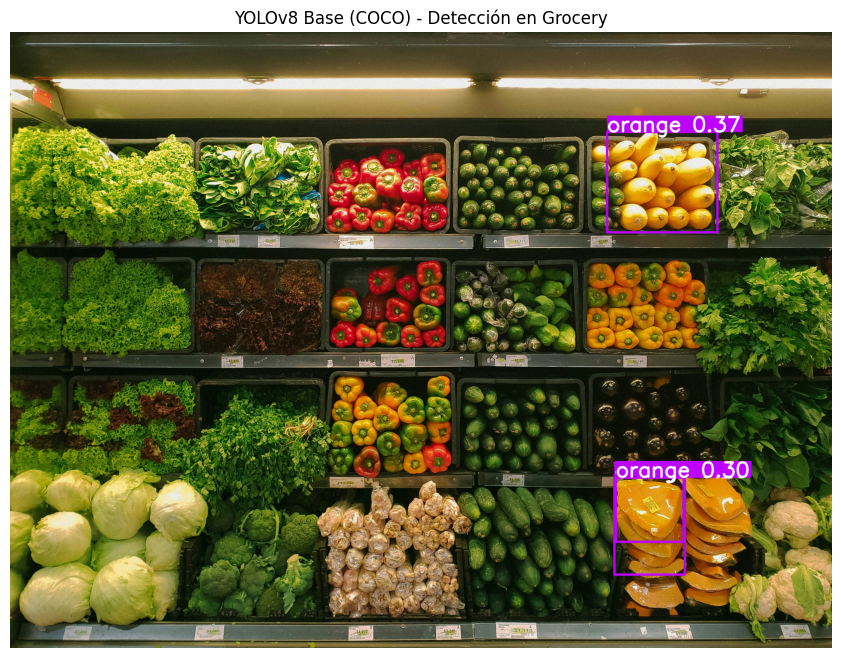


📊 Objetos detectados: 3
  1. orange: 0.367
  2. orange: 0.297
  3. orange: 0.289


In [ ]:
# Descargar la imagen
!wget https://images.unsplash.com/photo-1542838132-92c53300491e -O grocery_aisle.jpg

# Inferencia con modelo base
print("\n=== INFERENCIA CON MODELO BASE ===")

img_path = 'grocery_aisle.jpg'  # Ajustar según tu imagen

# Verificar que la imagen existe
if os.path.exists(img_path):
    # Fill in the blank: ¿Qué threshold de confianza usamos?
    results = model_base(img_path, conf=0.25) # Completa con un valor entre 0.1 y 0.5

    # Visualizar
    annotated = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('YOLOv8 Base (COCO) - Detección en Grocery')
    plt.show()

    # Analizar resultados
    boxes = results[0].boxes
    print(f"\n📊 Objetos detectados: {len(boxes)}")

    if len(boxes) > 0:
        for i, box in enumerate(boxes):
            cls_id = int(box.cls[0].cpu().numpy())
            conf = box.conf[0].cpu().numpy()
            class_name = model_base.names[cls_id]
            print(f"  {i+1}. {class_name}: {conf:.3f}")
    else:
        print("  ❌ No se detectaron objetos")
else:
    print(f"⚠️ Imagen no encontrada: {img_path}")
    print("   Por favor, descarga una imagen de productos de grocery")

1. Pudo detectar 3 productos
2. ninguna es correcta
3. No funciona bien por su limitacion de palabras, por ejemplo,lechuga o algun paquete de galletas en general. Ademas este modelo no fue entrenado para un contexto de supermercado.


In [ ]:
# TODO: Descargar "Fruit Detection Dataset" desde Kaggle

if not os.path.exists('kaggle.json'):
  print("Paso 1: Sube tu archivo kaggle.json")
  print("  (Ve a https://www.kaggle.com/settings → Create New API Token)")
  # Subir kaggle.json
  uploaded = files.upload()

  # Configurar Kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

# Instalar Kaggle CLI
!pip install -q kaggle

print("\n=== DESCARGANDO DATASET ===")
print("⏱️ Esto puede tomar 2-3 minutos...")

# Descargar dataset de frutas en formato YOLO
!kaggle datasets download -d lakshaytyagi01/fruit-detection
!unzip -q fruit-detection.zip -d fruit_detection

print("\n✅ Dataset descargado en: fruit_detection/")

# Explorar estructura
print("\n📁 Estructura del dataset:")
!ls -lh fruit_detection/

print("\n📂 Verificando carpetas:")
!ls fruit_detection/

# Contar imágenes por split
print("\n📊 Estadísticas:")
!find fruit_detection -name "*.jpg" -o -name "*.png" | wc -l | xargs echo "Total de imágenes:"


=== DESCARGANDO DATASET ===
⏱️ Esto puede tomar 2-3 minutos...
Dataset URL: https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection
License(s): CC0-1.0
fruit-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace fruit_detection/Fruits-detection/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace fruit_detection/Fruits-detection/cli.log? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace fruit_detection/Fruits-detection/cli.log? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

✅ Dataset descargado en: fruit_detection/

📁 Estructura del dataset:
total 4.0K
drwxr-xr-x 5 root root 4.0K Nov  9 14:35 Fruits-detection

📂 Verificando carpetas:
Fruits-detection

📊 Estadísticas:
Total de imágenes: 8479


In [ ]:
# TODO: Verificar que el dataset está en formato YOLO correcto

import yaml
from pathlib import Path
import glob

dataset_path = Path('fruit_detection')

print("\n=== VERIFICANDO ESTRUCTURA DEL DATASET ===")

# Explorar estructura
print("\n📁 Estructura completa:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    if level > 2:
        break
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... ({len(files)} archivos más)')

# Buscar data.yaml
yaml_files = list(dataset_path.glob('**/data.yaml'))

if yaml_files:
    yaml_path = yaml_files[0]
    print(f"\n✅ Encontrado data.yaml en: {yaml_path}")

    # Leer y verificar
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    print(f"\n=== CONFIGURACIÓN DEL DATASET ===")
    print(f"Número de clases: {data_config.get('nc', 'N/A')}")
    print(f"Clases: {data_config.get('names', 'N/A')}")
    print(f"Train path: {data_config.get('train', 'N/A')}")
    print(f"Val path: {data_config.get('val', 'N/A')}")

    # Guardar path para uso posterior
    yaml_path_str = str(yaml_path)

else:
    print("\n⚠️ No se encontró data.yaml, creando uno...")

    # Detectar estructura
    # Opciones comunes: train/images, valid/images o images/train, images/val
    train_dirs = list(dataset_path.glob('**/train/images')) + \
                 list(dataset_path.glob('**/images/train'))
    val_dirs = list(dataset_path.glob('**/valid/images')) + \
               list(dataset_path.glob('**/val/images')) + \
               list(dataset_path.glob('**/images/val'))

    if train_dirs and val_dirs:
        train_path = str(train_dirs[0].relative_to(dataset_path))
        val_path = str(val_dirs[0].relative_to(dataset_path))
    else:
        # Estructura por defecto
        train_path = 'train/images'
        val_path = 'valid/images'

    # Clases del Fruit Detection Dataset
    fruit_classes = ['apple', 'banana', 'grapes', 'orange', 'pineapple', 'watermelon']

    # Crear data.yaml
    data_config = {
        'path': str(dataset_path.absolute()),
        'train': train_path,
        'val': val_path,
        'nc': len(fruit_classes),
        'names': fruit_classes
    }

    yaml_path = dataset_path / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print(f"✅ data.yaml creado en: {yaml_path}")
    yaml_path_str = str(yaml_path)

# Contar imágenes reales
train_images = list(dataset_path.glob(f"{data_config['train']}/*.jpg")) + \
               list(dataset_path.glob(f"{data_config['train']}/*.png"))
val_images = list(dataset_path.glob(f"{data_config['val']}/*.jpg")) + \
             list(dataset_path.glob(f"{data_config['val']}/*.png"))

print(f"\n📊 ESTADÍSTICAS FINALES:")
print(f"  Train images: {len(train_images)}")
print(f"  Val images: {len(val_images)}")
print(f"  Total: {len(train_images) + len(val_images)}")
print(f"  Clases: {data_config['nc']}")

print(f"\n✅ Dataset listo para fine-tuning!")
print(f"   Path del data.yaml: {yaml_path_str}")


=== VERIFICANDO ESTRUCTURA DEL DATASET ===

📁 Estructura completa:
fruit_detection/
  Fruits-detection/
    yolov8s.pt
    README.txt
    data.yaml
    ... (5 archivos más)
    train/

✅ Encontrado data.yaml en: fruit_detection/Fruits-detection/data.yaml

=== CONFIGURACIÓN DEL DATASET ===
Número de clases: 6
Clases: ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']
Train path: E:\DL\attempt1\attempt3\datasets\Fruits-detection-1\train\images
Val path: E:\DL\attempt1\attempt3\datasets\Fruits-detection-1\valid\images

📊 ESTADÍSTICAS FINALES:
  Train images: 0
  Val images: 0
  Total: 0
  Clases: 6

✅ Dataset listo para fine-tuning!
   Path del data.yaml: fruit_detection/Fruits-detection/data.yaml



=== EXPLORANDO DATASET ===
Train labels: fruit_detection/Fruits-detection/train/labels
Val labels: fruit_detection/Fruits-detection/valid/labels

=== DISTRIBUCIÓN DE CLASES (TRAIN) ===
Total de clases: 6
Clases del dataset: ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']

Apple               : 6070 instancias
Banana              : 2971 instancias
Grape               : 6027 instancias
Orange              : 13938 instancias
Pineapple           : 1372 instancias
Watermelon          : 1683 instancias


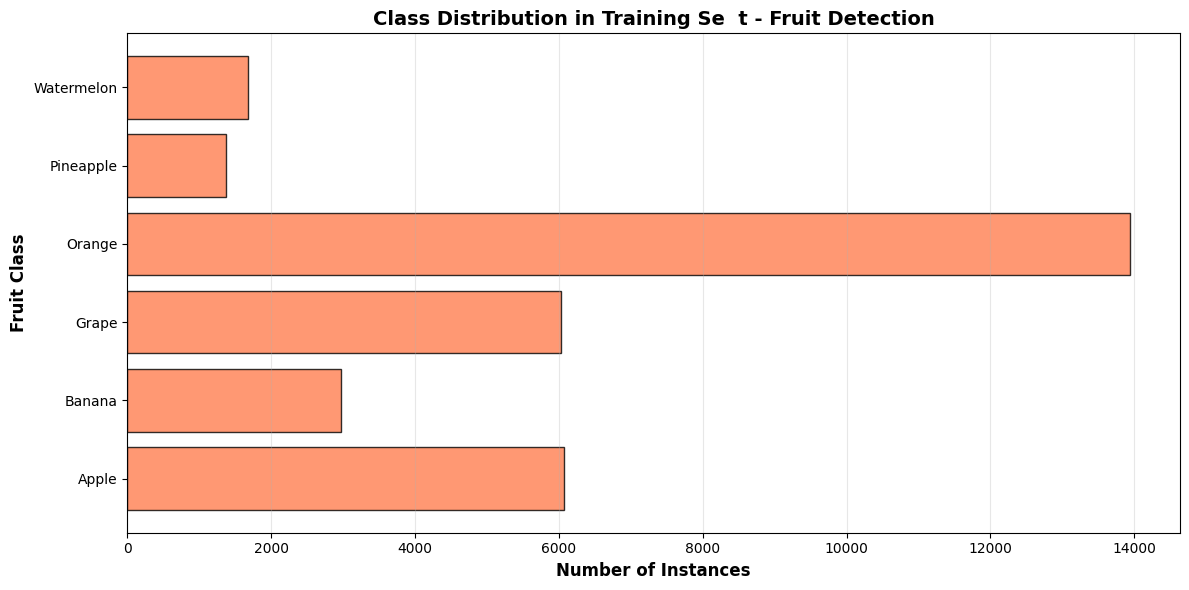


📊 ESTADÍSTICAS ADICIONALES:
  Instancias totales: 32061
  Promedio por clase: 5343.5
  Clase más frecuente: Orange (13938 instancias)
  Clase menos frecuente: Pineapple (1372 instancias)


In [ ]:
# TODO: Explorar distribución de clases y ejemplos

import glob
from collections import Counter

# Buscar carpetas de train/val (puede variar según estructura)
train_label_dir = list(dataset_path.glob('**/train/labels'))
val_label_dir = list(dataset_path.glob('**/valid/labels')) or list(dataset_path.glob('**/val/labels'))

if not train_label_dir:
    print("⚠️ Ajustando rutas de labels...")
    train_label_dir = [dataset_path / 'train' / 'labels']
    val_label_dir = [dataset_path / 'valid' / 'labels']

train_labels_path = str(train_label_dir[0])
val_labels_path = str(val_label_dir[0]) if val_label_dir else None

print(f"\n=== EXPLORANDO DATASET ===")
print(f"Train labels: {train_labels_path}")
print(f"Val labels: {val_labels_path}")

# Analizar distribución de clases en labels
def count_classes_in_labels(label_dir):
    """Contar ocurrencias de cada clase en labels"""
    class_counts = Counter()

    label_files = glob.glob(f"{label_dir}/*.txt")
    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

    return class_counts

train_class_counts = count_classes_in_labels(train_labels_path)

print(f"\n=== DISTRIBUCIÓN DE CLASES (TRAIN) ===")
print(f"Total de clases: {len(train_class_counts)}")
print(f"Clases del dataset: {data_config['names']}\n")

for class_id, count in sorted(train_class_counts.items()):
    if class_id < len(data_config['names']):
        class_name = data_config['names'][class_id]
        print(f"{class_name:20s}: {count:4d} instancias")

# Visualizar distribución
plt.figure(figsize=(12, 6))
class_names = [data_config['names'][i] for i in sorted(train_class_counts.keys())
               if i < len(data_config['names'])]
counts = [train_class_counts[i] for i in sorted(train_class_counts.keys())
          if i < len(data_config['names'])]

plt.barh(class_names, counts, color='coral', alpha=0.8, edgecolor='black')
plt.xlabel('Number of Instances', fontsize=12, fontweight='bold')
plt.ylabel('Fruit Class', fontsize=12, fontweight='bold')
plt.title('Class Distribution in Training Se  t - Fruit Detection', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n📊 ESTADÍSTICAS ADICIONALES:")
print(f"  Instancias totales: {sum(counts)}")
print(f"  Promedio por clase: {sum(counts) / len(counts):.1f}")
print(f"  Clase más frecuente: {class_names[counts.index(max(counts))]} ({max(counts)} instancias)")
print(f"  Clase menos frecuente: {class_names[counts.index(min(counts))]} ({min(counts)} instancias)")

- No esta balanceada, esto puede ser por sesgos, la furta no tiene la misma disponibilidad en todos lados a demas de ser muy variada.
- Orange es la que tiene mas instancias, creo que si sin duda.
- es probable que el que tenga menor distribucion tenga mas errores al predecir por el desbalance. puede ser overfitting o bajo recall.
- agrgaria de las que tienen menos instancias ejemplo banana.


=== VISUALIZANDO EJEMPLOS ===
Encontradas 7108 imágenes de training


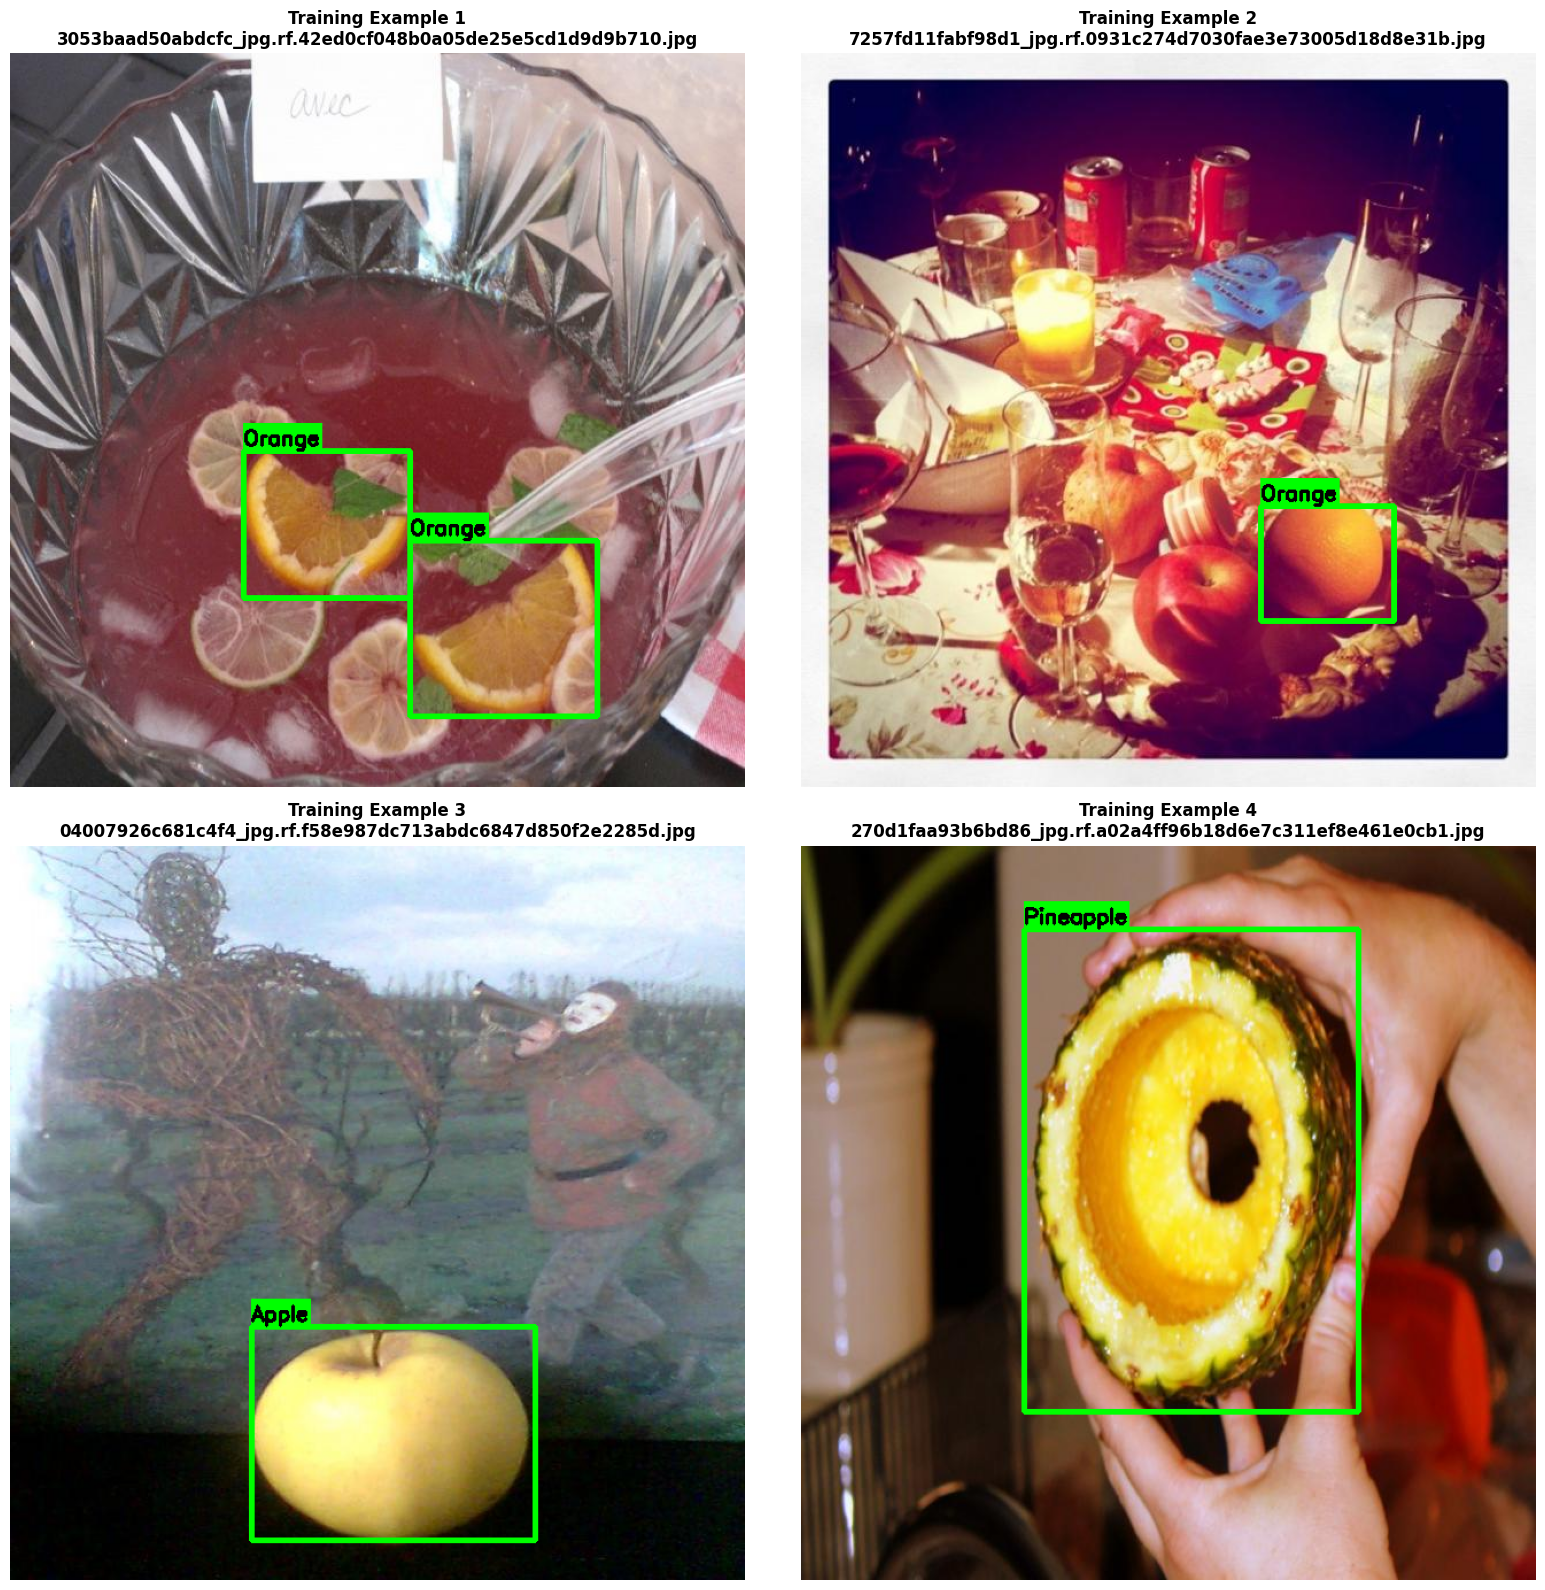


✅ Visualizadas 4 imágenes de ejemplo


In [ ]:
# TODO: Visualizar algunas imágenes con annotations

# Buscar imágenes de training
train_img_dirs = list(dataset_path.glob('**/train/images'))
if not train_img_dirs:
    train_img_dirs = list(dataset_path.glob('**/images/train'))

if train_img_dirs:
    train_img_path = train_img_dirs[0]
    train_images_list = list(train_img_path.glob('*.jpg')) + list(train_img_path.glob('*.png'))

    print(f"\n=== VISUALIZANDO EJEMPLOS ===")
    print(f"Encontradas {len(train_images_list)} imágenes de training")

    if len(train_images_list) == 0:
        print("⚠️ No se encontraron imágenes. Verifica la estructura del dataset.")
    else:
        def visualize_sample(image_path, label_path, class_names):
            """Visualizar imagen con bounding boxes"""
            img = cv2.imread(str(image_path))
            if img is None:
                print(f"⚠️ No se pudo leer imagen: {image_path}")
                return None

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img_rgb.shape[:2]

            # Leer labels
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            x_center, y_center, width, height = map(float, parts[1:5])

                            # Convertir a coordenadas absolutas
                            x1 = int((x_center - width/2) * w)
                            y1 = int((y_center - height/2) * h)
                            x2 = int((x_center + width/2) * w)
                            y2 = int((y_center + height/2) * h)

                            # Dibujar box
                            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

                            # Label con background
                            if class_id < len(class_names):
                                label = class_names[class_id]
                                (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                                cv2.rectangle(img_rgb, (x1, y1-label_h-10), (x1+label_w, y1), (0, 255, 0), -1)
                                cv2.putText(img_rgb, label, (x1, y1-5),
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

            return img_rgb

        # Determinar cuántas imágenes mostrar
        num_samples = min(4, len(train_images_list))

        # Visualizar ejemplos random
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        axes = axes.flatten()

        sample_images = random.sample(train_images_list, num_samples)

        for i, img_path in enumerate(sample_images):
            # Construir path del label
            label_path = str(img_path).replace('/images/', '/labels/').replace('.jpg', '.txt').replace('.png', '.txt')

            img_with_boxes = visualize_sample(img_path, label_path, data_config['names'])

            if img_with_boxes is not None:
                axes[i].imshow(img_with_boxes)
                axes[i].axis('off')
                axes[i].set_title(f'Training Example {i+1}\n{img_path.name}', fontsize=12, fontweight='bold')

        # Ocultar subplots vacíos
        for i in range(num_samples, 4):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n✅ Visualizadas {num_samples} imágenes de ejemplo")
else:
    print("⚠️ No se encontró carpeta de imágenes de training")


---




=== PREPARANDO FINE-TUNING ===

📄 Leyendo data.yaml: fruit_detection/Fruits-detection/data.yaml
   Config actual: {'names': ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon'], 'nc': 6, 'test': 'E:\\DL\\attempt1\\attempt3\\datasets\\Fruits-detection-1\\test\\images', 'train': 'E:\\DL\\attempt1\\attempt3\\datasets\\Fruits-detection-1\\train\\images', 'val': 'E:\\DL\\attempt1\\attempt3\\datasets\\Fruits-detection-1\\valid\\images'}

📁 Dataset root: fruit_detection/Fruits-detection
✅ Detectadas rutas correctas:
   Train: train/images
   Valid: valid/images

✅ data.yaml corregido guardado en: fruit_detection/Fruits-detection/data_fixed.yaml

Config corregido:
  path: /content/fruit_detection/Fruits-detection
  train: train/images
  val: valid/images
  nc: 6
  names: ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']

=== INICIANDO FINE-TUNING ===
⚡ Configuración ultra-rápida para clase:

📋 Configuración:
   Data YAML: fruit_detection/Fruits-detection/data_fixe

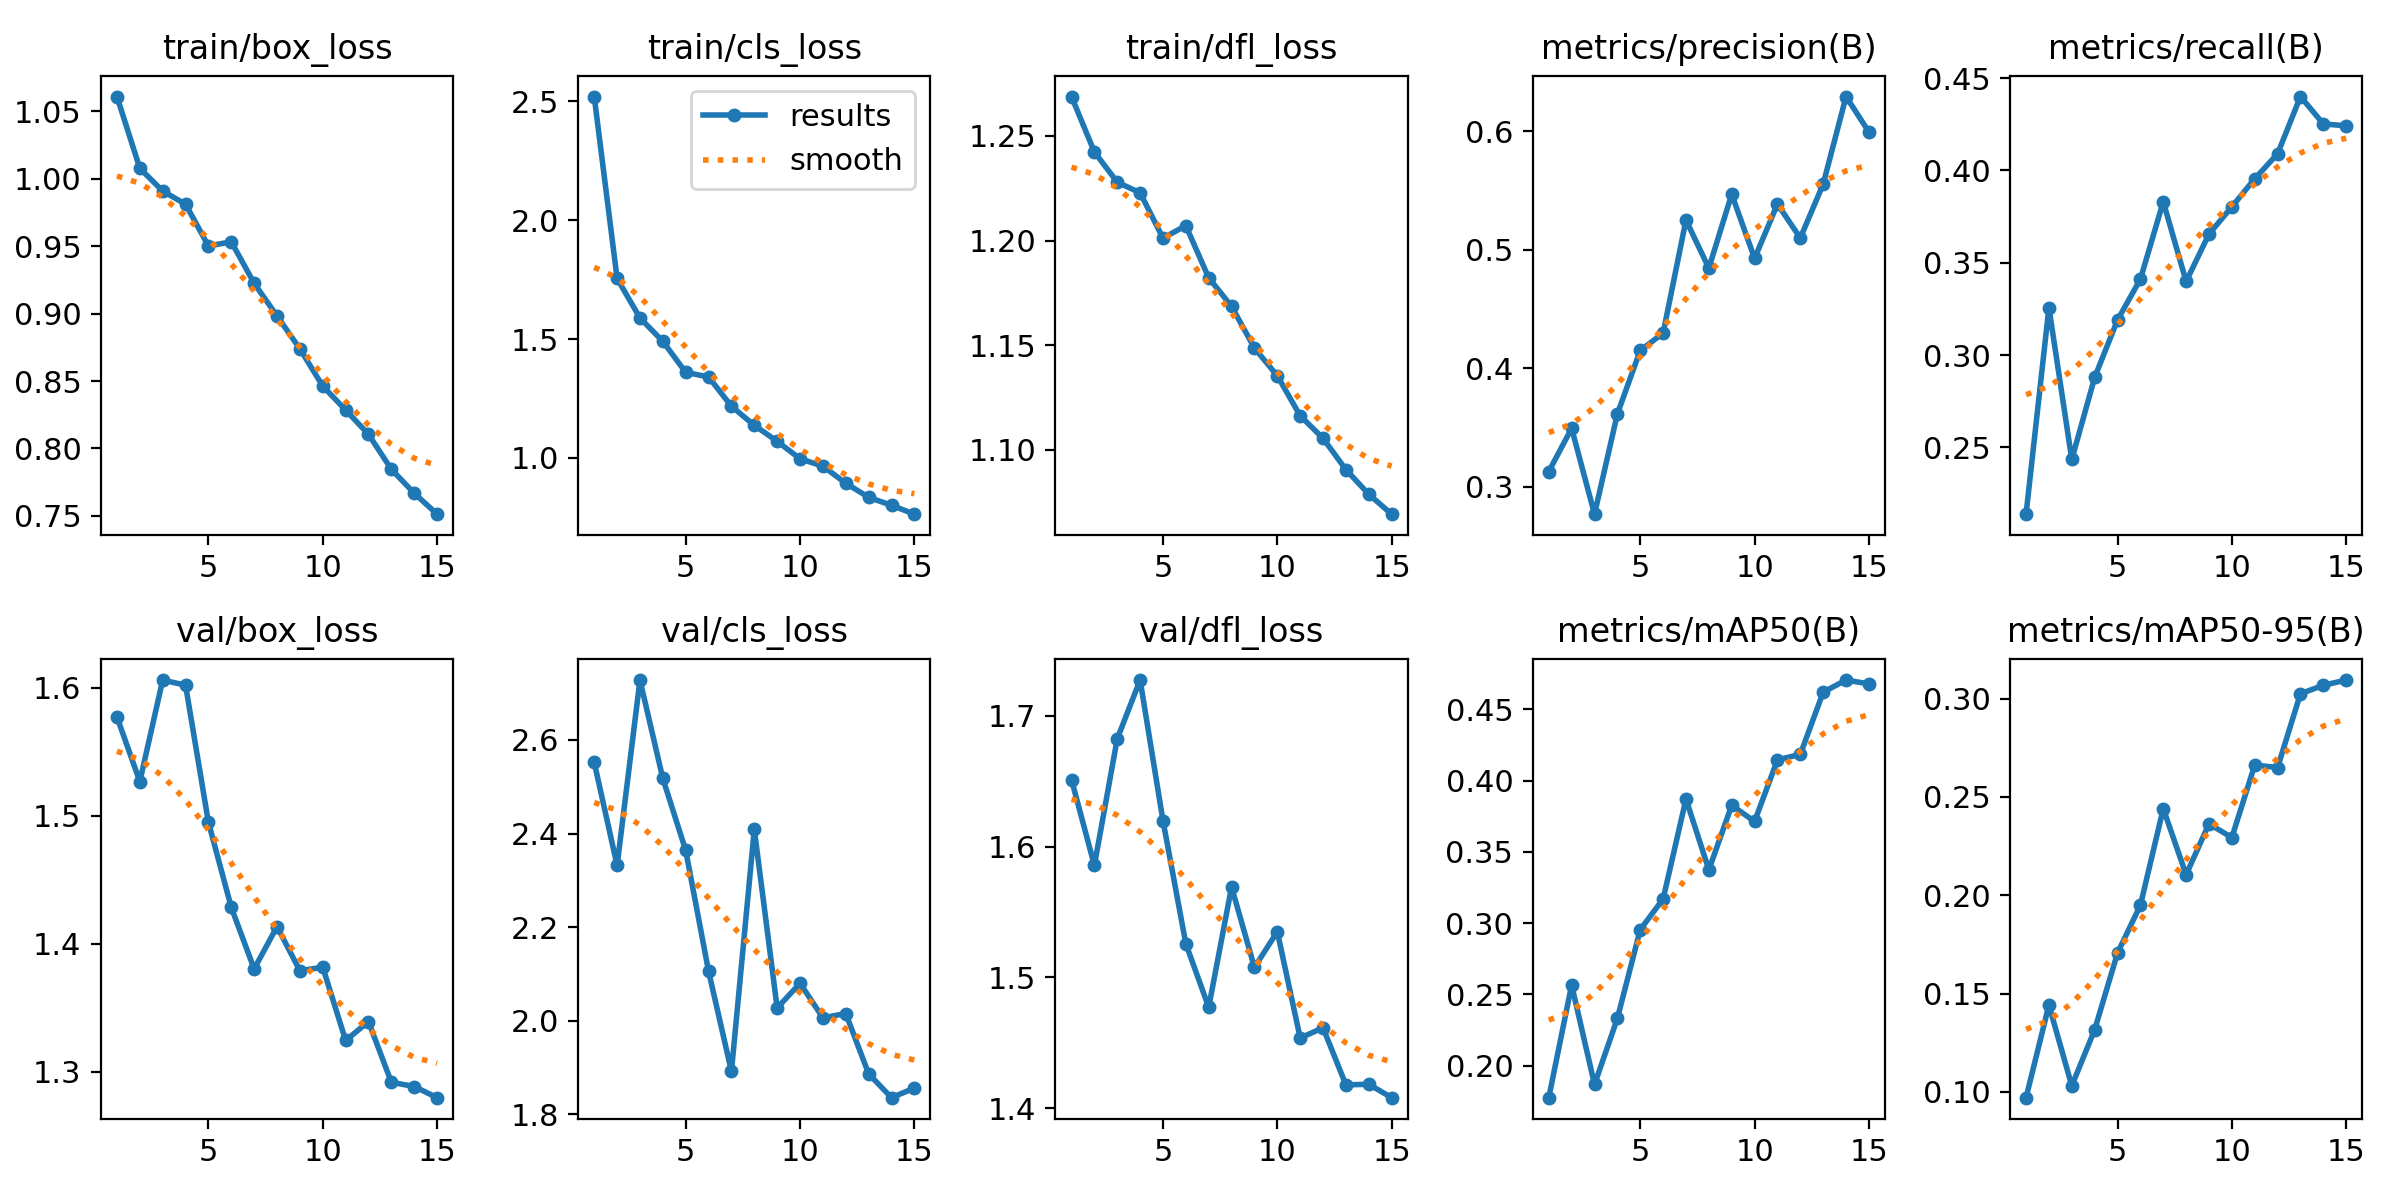

In [ ]:
# TODO: Arreglar rutas en data.yaml y ejecutar fine-tuning

print("\n=== PREPARANDO FINE-TUNING ===")

# Verificar que tenemos el path del data.yaml
if 'yaml_path_str' not in locals():
    yaml_path_str = str(dataset_path / 'data.yaml')
    print(f"⚠️ Usando path por defecto: {yaml_path_str}")

# Leer el data.yaml actual
print(f"\n📄 Leyendo data.yaml: {yaml_path_str}")
with open(yaml_path_str, 'r') as f:
    data_config_current = yaml.safe_load(f)

print(f"   Config actual: {data_config_current}")

# El dataset puede tener rutas absolutas de Windows que no funcionan en Colab
# Necesitamos arreglar esto con rutas relativas correctas

# Detectar estructura real del dataset
dataset_root = Path(yaml_path_str).parent
print(f"\n📁 Dataset root: {dataset_root}")

# Buscar carpetas train y valid
train_img_dirs = list(dataset_root.glob('**/train/images')) or list(dataset_root.glob('**/images/train'))
valid_img_dirs = list(dataset_root.glob('**/valid/images')) or list(dataset_root.glob('**/val/images'))

if train_img_dirs and valid_img_dirs:
    train_path = str(train_img_dirs[0].relative_to(dataset_root))
    valid_path = str(valid_img_dirs[0].relative_to(dataset_root))
    print(f"✅ Detectadas rutas correctas:")
    print(f"   Train: {train_path}")
    print(f"   Valid: {valid_path}")
else:
    # Fallback a rutas comunes
    train_path = 'train/images'
    valid_path = 'valid/images'
    print(f"⚠️ Usando rutas por defecto: {train_path}, {valid_path}")

# Crear data.yaml corregido
data_config_fixed = {
    'path': str(dataset_root.absolute()),
    'train': train_path,
    'val': valid_path,
    'nc': data_config_current.get('nc', 6),
    'names': data_config_current.get('names', ['apple', 'banana', 'grapes', 'orange', 'pineapple', 'watermelon'])
}

# Guardar data.yaml corregido
yaml_fixed_path = dataset_root / 'data_fixed.yaml'
with open(yaml_fixed_path, 'w') as f:
    yaml.dump(data_config_fixed, f, default_flow_style=False)

print(f"\n✅ data.yaml corregido guardado en: {yaml_fixed_path}")
print(f"\nConfig corregido:")
for key, value in data_config_fixed.items():
    print(f"  {key}: {value}")

# Usar el yaml corregido para training
yaml_path_str = str(yaml_fixed_path)

print(f"\n=== INICIANDO FINE-TUNING ===")
print("⚡ Configuración ultra-rápida para clase:")

print(f"\n📋 Configuración:")
print(f"   Data YAML: {yaml_path_str}")
print(f"   Modelo base: YOLOv8n")

# Fill in the blanks: Configurar hyperparámetros de training
EPOCHS = 15       # Completa: Número de epochs (típico: 10-50)
BATCH_SIZE = 32    # Completa: Batch size (típico: 16-32)
IMAGE_SIZE = 640    # Completa: Tamaño de imagen (típico: 640)
FRACTION = 1      # Completa: Fracción del dataset (0.25 = 25% del dataset para rapidez)


# Crear modelo nuevo basado en YOLOv8n (el más pequeño y rápido)
# Fill in the blank: ¿Qué modelo base cargamos?
model = YOLO('yolov8n.pt')  # Completa con 'yolov8n.pt'

print(f"\n🚀 Iniciando training con {EPOCHS} epochs...")
print("   ⏱️ Tiempo estimado: 3-4 minutos ⚡")

# Fine-tune con subset del dataset
results = model.train(
    data=yaml_path_str,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    fraction=FRACTION,
    name='fruit_finetuned',
    patience=5,
    save=True,
    plots=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='runs/detect',
    verbose=True
)

print("\n✅ Fine-tuning completado!")

# Obtener el path real del training (puede ser fruit_finetuned, fruit_finetuned2, etc.)
training_dir = results.save_dir
print(f"   Modelo guardado en: {training_dir}")
print(f"   Weights: {training_dir}/weights/best.pt")

# Visualizar gráficos de training
print("\n📊 Gráficos de training guardados en:")
print(f"   {training_dir}/results.png")

# Mostrar resultados finales

results_png = f"{training_dir}/results.png"
if os.path.exists(results_png):
    print("\n=== RESULTADOS DEL TRAINING ===")
    display(Image(filename=results_png))
else:
    print(f"\n⚠️ Gráficos no encontrados en {results_png}")

- box_loss , mide que tan incorrectas son las coordenadas de las cajas que predice el modelo. Fue disminuyendo con los epochs. Mientras mas cerca del 0 significa que se alinean perfectamente con las cajas del dataset.
- cls_loss Mide que tan confundido esta el modelo sobre que es el objeto dentro de la caja. Si es alto significa que el modelo comente errores de clasificacion. A medida que el modelo fue aprendiendo fue bajando rapidamente.
-

In [ ]:
# TODO: Cargar el mejor modelo del training

# Usar el path del training anterior (guardado en training_dir)
# training_dir viene del paso 2.4
# Fill in the blank: ¿Qué archivo de weights cargamos?
best_weights_path = f"{training_dir}/weights/best.pt"  # Completa: 'best.pt' o 'last.pt'

print(f"\n=== CARGANDO MODELO FINE-TUNED ===")
print(f"Path: {best_weights_path}")

# Cargar mejor checkpoint (best.pt = mejor mAP durante validation)
model_finetuned = YOLO(best_weights_path)

print("\n✅ Modelo fine-tuned cargado")
print(f"   Clases: {list(model_finetuned.names.values())}")
print(f"   Total de clases: {len(model_finetuned.names)}")

# Comparar con modelo base
print("\n📊 Comparación:")
print(f"   Modelo base (COCO): 80 clases (genéricas)")
print(f"   Modelo fine-tuned: {len(model_finetuned.names)} clases (frutas específicas)")
print(f"   Mejora: Especializado en detección de frutas")


=== CARGANDO MODELO FINE-TUNED ===
Path: /content/runs/detect/fruit_finetuned2/weights/best.pt

✅ Modelo fine-tuned cargado
   Clases: ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']
   Total de clases: 6

📊 Comparación:
   Modelo base (COCO): 80 clases (genéricas)
   Modelo fine-tuned: 6 clases (frutas específicas)
   Mejora: Especializado en detección de frutas


In [ ]:
# TODO: Evaluar modelo en validation set

print("\n=== EVALUACIÓN EN VALIDATION SET ===")

# Validar modelo fine-tuned
metrics = model_finetuned.val()

print(f"\n📊 MÉTRICAS DEL MODELO FINE-TUNED:")
print(f"  mAP@0.5:     {metrics.box.map50:.3f}")
print(f"  mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"  Precision:   {metrics.box.mp:.3f}")
print(f"  Recall:      {metrics.box.mr:.3f}")

# Métricas por clase
print(f"\n=== MÉTRICAS POR CLASE ===")
for i, class_name in enumerate(model_finetuned.names.values()):
    if i < len(metrics.box.maps):
        print(f"{class_name:20s}: mAP@0.5 = {metrics.box.maps[i]:.3f}")


=== EVALUACIÓN EN VALIDATION SET ===
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1886.4±753.8 MB/s, size: 53.7 KB)
val: Scanning /content/fruit_detection/Fruits-detection/valid/labels.cache... 914 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 914/914 1.7Mit/s 0.0s
val: /content/fruit_detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 58/58 5.9it/s 9.9s
                   all        914       3227      0.598      0.425      0.467      0.309
                 Apple        188        557      0.598      0.416       0.47      0.326
                Banana        167        390      0.605      0.421      0.475      0.281
                


=== COMPARACIÓN: BASE vs FINE-TUNED ===
Comparando en 3 imágenes del validation set


Imagen 1/3: 3e81175222f8c348_jpg.rf.64ef9bcbf46133a93ea7312407727886.jpg
  Modelo Base (COCO):   2 detecciones
  Modelo Fine-tuned:    3 detecciones
  Diferencia:          +1
  Clases (Base):       apple, orange
  Clases (Fine-tuned): Orange, Grape


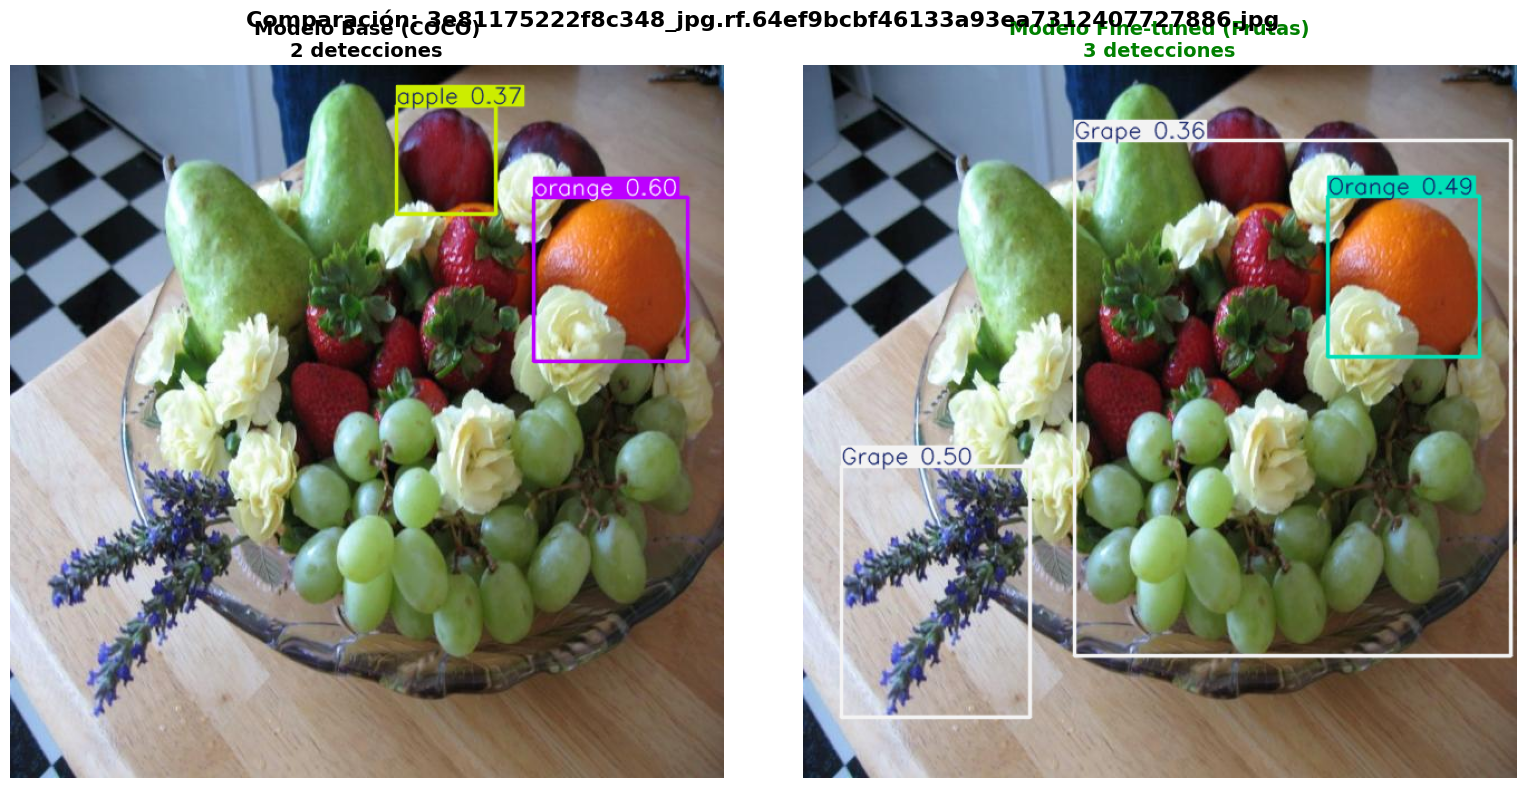


Imagen 2/3: 5f5b1d06e295c2cc_jpg.rf.a73e18391e21d1246a86cd366f0febbc.jpg
  Modelo Base (COCO):   0 detecciones
  Modelo Fine-tuned:    1 detecciones
  Diferencia:          +1
  Clases (Fine-tuned): Orange


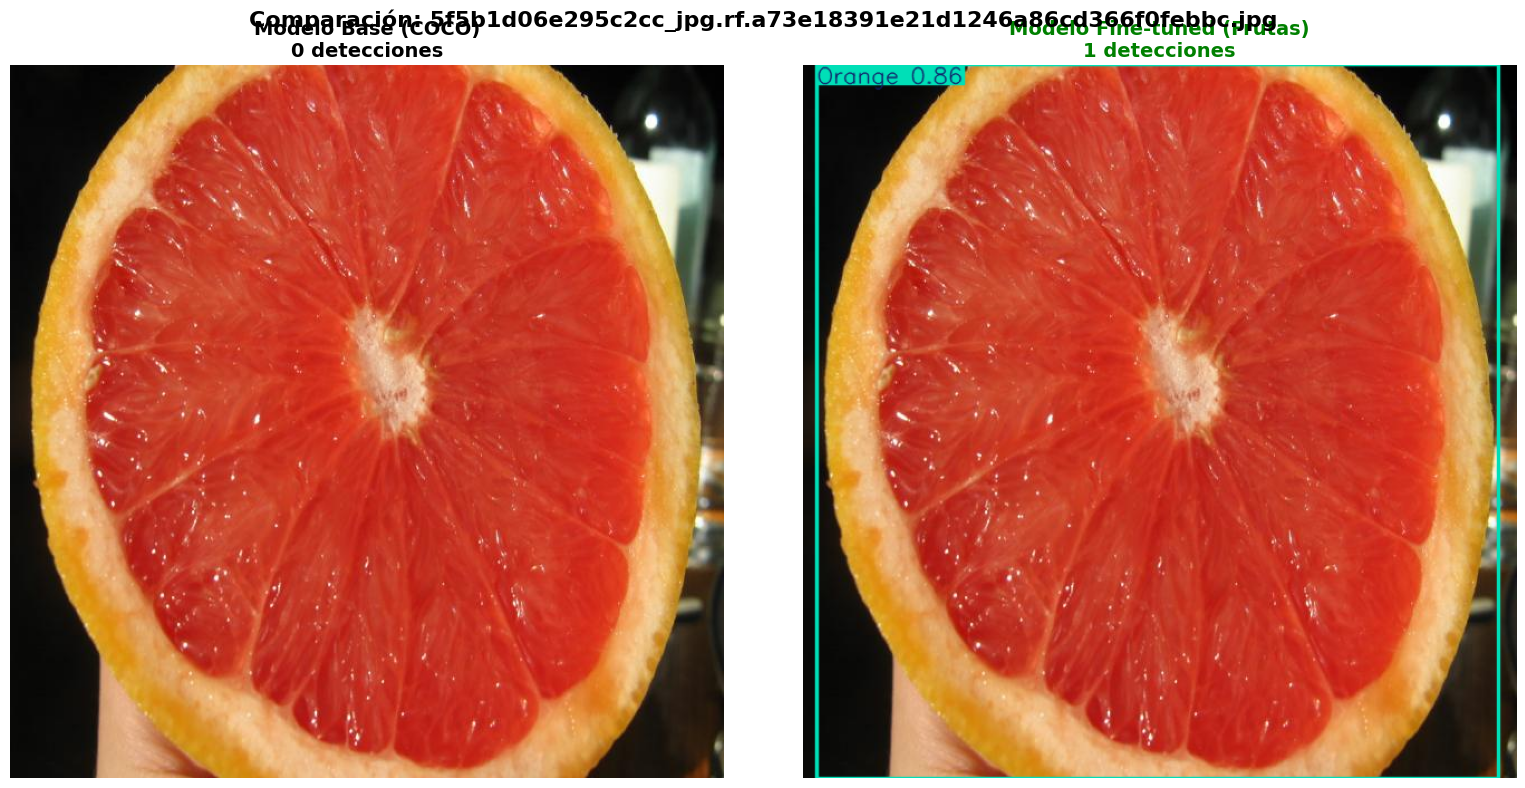


Imagen 3/3: bb199b34c5805576_jpg.rf.1746d23ff9448574de12e91cefed54b9.jpg
  Modelo Base (COCO):   2 detecciones
  Modelo Fine-tuned:    2 detecciones
  Diferencia:          +0
  Clases (Base):       apple
  Clases (Fine-tuned): Apple


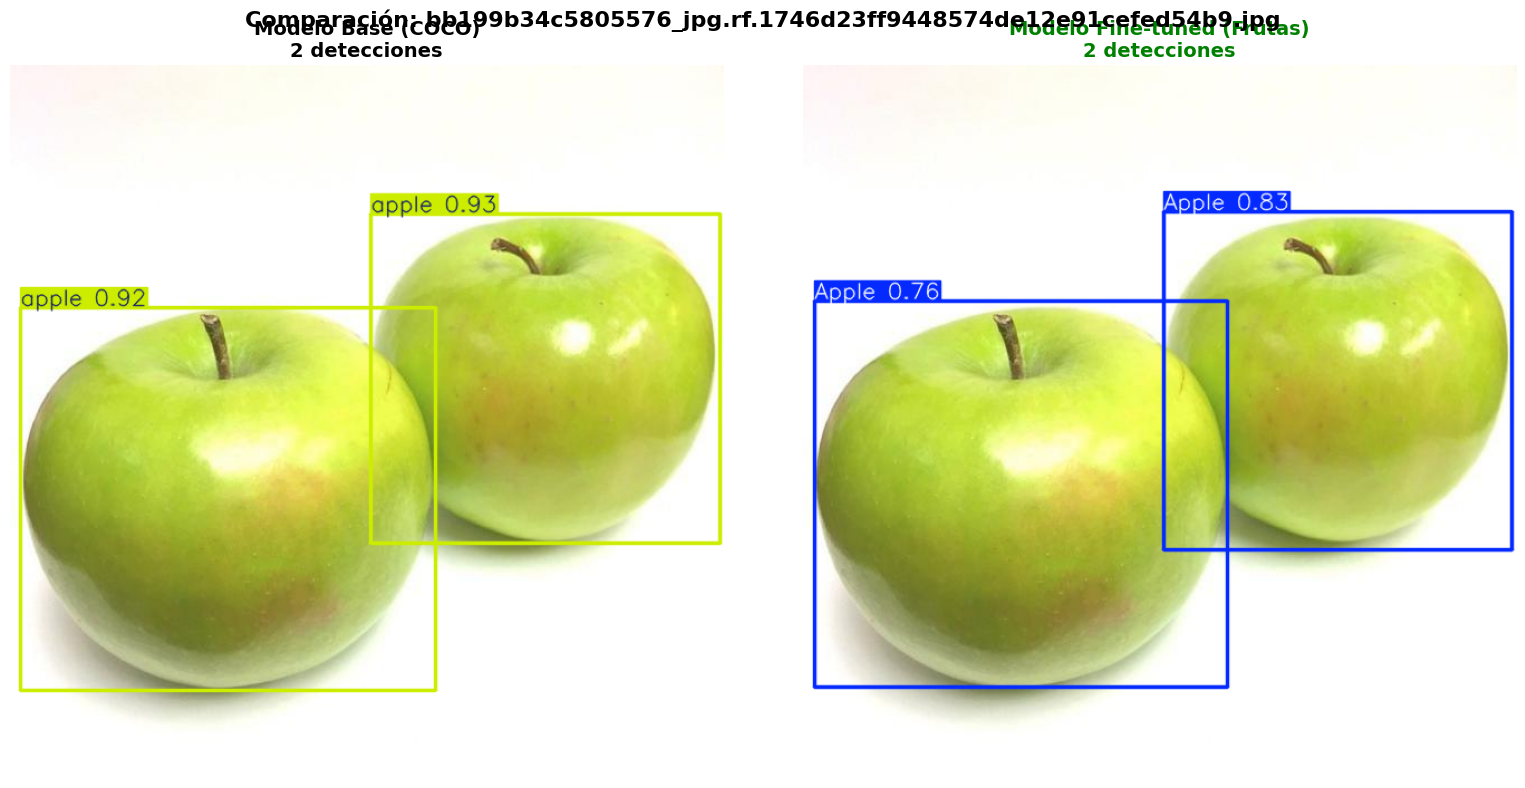


✅ Comparación completada


In [ ]:
# TODO: Comparar modelo base vs fine-tuned en mismas imágenes

# Usar dataset_path del paso 2.1b
# Buscar imágenes del validation set
val_img_dirs = list(dataset_path.glob('**/valid/images')) or list(dataset_path.glob('**/val/images'))

if val_img_dirs:
    val_img_path = val_img_dirs[0]
    val_images_list = list(val_img_path.glob('*.jpg')) + list(val_img_path.glob('*.png'))

    # Seleccionar 3 imágenes random para comparar
    num_samples = min(3, len(val_images_list))
    test_images_list = random.sample(val_images_list, num_samples)

    print(f"\n=== COMPARACIÓN: BASE vs FINE-TUNED ===")
    print(f"Comparando en {num_samples} imágenes del validation set\n")

    for idx, img_path in enumerate(test_images_list):
        img_name = img_path.name
        print(f"\n{'='*60}")
        print(f"Imagen {idx+1}/{num_samples}: {img_name}")

        # Inferencia con modelo base
        results_base = model_base(str(img_path), conf=0.3, verbose=False)
        n_detections_base = len(results_base[0].boxes)

        # Inferencia con modelo fine-tuned
        results_finetuned = model_finetuned(str(img_path), conf=0.3, verbose=False)
        n_detections_finetuned = len(results_finetuned[0].boxes)

        print(f"  Modelo Base (COCO):  {n_detections_base:2d} detecciones")
        print(f"  Modelo Fine-tuned:   {n_detections_finetuned:2d} detecciones")
        print(f"  Diferencia:          {n_detections_finetuned - n_detections_base:+d}")

        # Mostrar clases detectadas
        if n_detections_base > 0:
            base_classes = [model_base.names[int(box.cls[0])] for box in results_base[0].boxes]
            print(f"  Clases (Base):       {', '.join(set(base_classes))}")

        if n_detections_finetuned > 0:
            ft_classes = [model_finetuned.names[int(box.cls[0])] for box in results_finetuned[0].boxes]
            print(f"  Clases (Fine-tuned): {', '.join(set(ft_classes))}")

        # Visualizar comparación
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Base
        annotated_base = results_base[0].plot()
        axes[0].imshow(cv2.cvtColor(annotated_base, cv2.COLOR_BGR2RGB))
        axes[0].axis('off')
        axes[0].set_title(f'Modelo Base (COCO)\n{n_detections_base} detecciones',
                         fontsize=14, fontweight='bold')

        # Fine-tuned
        annotated_finetuned = results_finetuned[0].plot()
        axes[1].imshow(cv2.cvtColor(annotated_finetuned, cv2.COLOR_BGR2RGB))
        axes[1].axis('off')
        axes[1].set_title(f'Modelo Fine-tuned (Frutas)\n{n_detections_finetuned} detecciones',
                         fontsize=14, fontweight='bold', color='green')

        plt.suptitle(f'Comparación: {img_name}', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

    print(f"\n{'='*60}")
    print("✅ Comparación completada")
else:
    print("⚠️ No se encontraron imágenes del validation set")


=== ANÁLISIS DE ERRORES ===

=== RESULTADOS COMPARATIVOS ===

Modelo Base (COCO):
  TP: 0, FP: 4, FN: 4
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000

Modelo Fine-tuned:
  TP: 4, FP: 2, FN: 0
  Precision: 0.667
  Recall:    1.000
  F1-Score:  0.800

=== MEJORA ===
  Δ Precision: +0.667
  Δ Recall:    +1.000
  Δ F1-Score:  +0.800


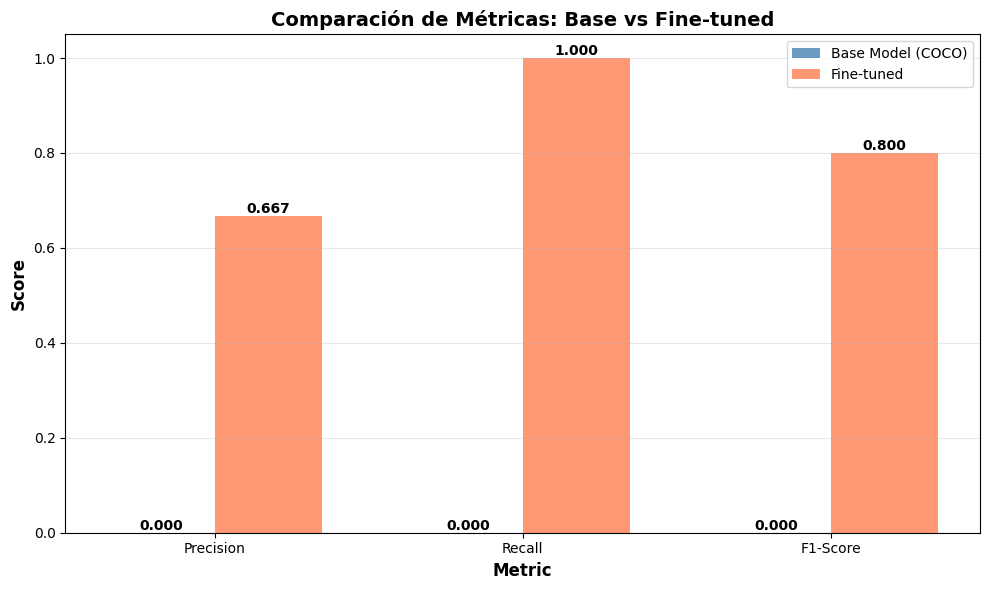

In [ ]:
 # TODO: Analizar False Positives y False Negatives

def calculate_metrics_from_results(results, ground_truths, iou_threshold=0.5):
    """
    Calcular TP, FP, FN dado resultados de inferencia y ground truths
    """
    predictions = results[0].boxes

    tp = 0
    fp = 0
    gt_matched = [False] * len(ground_truths)

    for pred_box in predictions:
        pred_xyxy = pred_box.xyxy[0].cpu().numpy()
        pred_cls = int(pred_box.cls[0].cpu().numpy())

        best_iou = 0
        best_gt_idx = -1

        for i, gt in enumerate(ground_truths):
            if gt_matched[i]:
                continue

            gt_cls = gt['class_id']
            if pred_cls != gt_cls:
                continue

            # Calcular IoU
            gt_xyxy = gt['xyxy']
            iou = calculate_iou(pred_xyxy, gt_xyxy)

            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        if best_iou >= iou_threshold and best_gt_idx >= 0:
            tp += 1
            gt_matched[best_gt_idx] = True
        else:
            fp += 1

    fn = len(ground_truths) - sum(gt_matched)

    return tp, fp, fn

def calculate_iou(box1, box2):
    """Calcular IoU entre dos boxes [x1, y1, x2, y2]"""
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    if x2_inter > x1_inter and y2_inter > y1_inter:
        inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        inter_area = 0

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

# Analizar errores en test set
print("\n=== ANÁLISIS DE ERRORES ===")

total_tp_base = 0
total_fp_base = 0
total_fn_base = 0

total_tp_finetuned = 0
total_fp_finetuned = 0
total_fn_finetuned = 0

# Analizar subset de validation images
# test_images_list viene del paso 2.7 y contiene Path objects
num_analyze = min(10, len(test_images_list))

for img_path in test_images_list[:num_analyze]:
    # Convertir Path a string y construir label path
    img_path_str = str(img_path)
    label_path = img_path_str.replace('/images/', '/labels/').replace('.jpg', '.txt').replace('.png', '.txt')

    # Leer ground truths
    ground_truths = []
    if os.path.exists(label_path):
        img = cv2.imread(img_path_str)
        if img is None:
            continue
        h, w = img.shape[:2]

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])

                    x1 = (x_center - width/2) * w
                    y1 = (y_center - height/2) * h
                    x2 = (x_center + width/2) * w
                    y2 = (y_center + height/2) * h

                    ground_truths.append({
                        'class_id': class_id,
                        'xyxy': [x1, y1, x2, y2]
                    })

    if len(ground_truths) == 0:
        continue

    # Calcular métricas
    results_base = model_base(img_path_str, conf=0.3, verbose=False)
    tp_base, fp_base, fn_base = calculate_metrics_from_results(results_base, ground_truths)

    results_finetuned = model_finetuned(img_path_str, conf=0.3, verbose=False)
    tp_finetuned, fp_finetuned, fn_finetuned = calculate_metrics_from_results(results_finetuned, ground_truths)

    total_tp_base += tp_base
    total_fp_base += fp_base
    total_fn_base += fn_base

    total_tp_finetuned += tp_finetuned
    total_fp_finetuned += fp_finetuned
    total_fn_finetuned += fn_finetuned

# Calcular métricas finales
precision_base = total_tp_base / (total_tp_base + total_fp_base) if (total_tp_base + total_fp_base) > 0 else 0
recall_base = total_tp_base / (total_tp_base + total_fn_base) if (total_tp_base + total_fn_base) > 0 else 0
f1_base = 2 * (precision_base * recall_base) / (precision_base + recall_base) if (precision_base + recall_base) > 0 else 0

precision_finetuned = total_tp_finetuned / (total_tp_finetuned + total_fp_finetuned) if (total_tp_finetuned + total_fp_finetuned) > 0 else 0
recall_finetuned = total_tp_finetuned / (total_tp_finetuned + total_fn_finetuned) if (total_tp_finetuned + total_fn_finetuned) > 0 else 0
f1_finetuned = 2 * (precision_finetuned * recall_finetuned) / (precision_finetuned + recall_finetuned) if (precision_finetuned + recall_finetuned) > 0 else 0

print(f"\n=== RESULTADOS COMPARATIVOS ===")
print(f"\nModelo Base (COCO):")
print(f"  TP: {total_tp_base}, FP: {total_fp_base}, FN: {total_fn_base}")
print(f"  Precision: {precision_base:.3f}")
print(f"  Recall:    {recall_base:.3f}")
print(f"  F1-Score:  {f1_base:.3f}")

print(f"\nModelo Fine-tuned:")
print(f"  TP: {total_tp_finetuned}, FP: {total_fp_finetuned}, FN: {total_fn_finetuned}")
print(f"  Precision: {precision_finetuned:.3f}")
print(f"  Recall:    {recall_finetuned:.3f}")
print(f"  F1-Score:  {f1_finetuned:.3f}")

print(f"\n=== MEJORA ===")
print(f"  Δ Precision: {(precision_finetuned - precision_base):+.3f}")
print(f"  Δ Recall:    {(recall_finetuned - recall_base):+.3f}")
print(f"  Δ F1-Score:  {(f1_finetuned - f1_base):+.3f}")

# Visualizar comparación
metrics_comparison = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Base Model': [precision_base, recall_base, f1_base],
    'Fine-tuned': [precision_finetuned, recall_finetuned, f1_finetuned]
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_comparison['Base Model'], width,
               label='Base Model (COCO)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_comparison['Fine-tuned'], width,
               label='Fine-tuned', color='coral', alpha=0.8)

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas: Base vs Fine-tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Descargar video de frutas desde Google Drive

print("=== DESCARGANDO VIDEO PARA TRACKING ===")
print("Video de frutas en cinta transportadora\n")

# Instalar gdown para descargar desde Google Drive
!pip install -q gdown

import gdown

# Crear carpeta para videos
!mkdir -p videos

# Descargar video desde Google Drive
# URL: https://drive.google.com/file/d/1xPxrNgaCp2ECVIuHw5HZuAWL_vEbyvZ9/view?usp=sharing
file_id = '1xPxrNgaCp2ECVIuHw5HZuAWL_vEbyvZ9'
video_path = 'videos/fruits_tracking.mp4'
print("📥 Descargando video...")
gdown.download(f'https://drive.google.com/uc?id={file_id}', video_path, quiet=False)

# Verificar video descargado
if os.path.exists(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    print(f"\n✅ Video descargado exitosamente:")
    print(f"   Path: {video_path}")
    print(f"   FPS: {fps}")
    print(f"   Frames: {frame_count}")
    print(f"   Resolución: {width}×{height}")
    if fps > 0:
        print(f"   Duración: {frame_count/fps:.1f} segundos")
    else:
        print("   ⚠️ Advertencia: FPS = 0, el video puede estar corrupto")
else:
    print("❌ Error: No se pudo descargar el video")
    print("   Verifica la conexión a internet y el link de Google Drive")
    video_path = None

=== DESCARGANDO VIDEO PARA TRACKING ===
Video de frutas en cinta transportadora

📥 Descargando video...


Downloading...
From: https://drive.google.com/uc?id=1xPxrNgaCp2ECVIuHw5HZuAWL_vEbyvZ9
To: /content/videos/fruits_tracking.mp4
100%|██████████| 833k/833k [00:00<00:00, 134MB/s]


✅ Video descargado exitosamente:
   Path: videos/fruits_tracking.mp4
   FPS: 29.97002997002997
   Frames: 343
   Resolución: 768×432
   Duración: 11.4 segundos


In [ ]:
# TODO: Instalar e inicializar Norfair tracker

# Instalar Norfair
!pip install -q norfair

from norfair import Detection, Tracker
from norfair.distances import mean_euclidean

print("=== CONFIGURANDO NORFAIR TRACKER ===")

# Fill in the blanks: Configurar parámetros del tracker
# distance_function: función para calcular distancia entre detecciones
# distance_threshold: umbral para matching (más bajo = más permisivo)
# hit_counter_max: frames sin detección antes de eliminar track (similar a max_age)
# initialization_delay: frames necesarios para confirmar un nuevo track
tracker = Tracker(
    distance_function=mean_euclidean,     # Distancia euclidiana media
    distance_threshold=100,
    hit_counter_max=15,
    initialization_delay=3
)

# 💡 Nota sobre el formato de detecciones:
# Los objetos Detection necesitan:
#   - points: np.array con shape (2, 2) para 2 corners → [[x1,y1], [x2,y2]]
#   - data: dict opcional para guardar metadata (ej: class_id, confidence)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


=== CONFIGURANDO NORFAIR TRACKER ===


In [ ]:
# TODO: Procesar video con modelo fine-tuned y tracking

if os.path.exists(video_path):
    cap = cv2.VideoCapture(video_path)

    # Configurar output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = 'videos/grocery_tracked.mp4'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    track_history = {}  # {track_id: [frame_indices]}
    detections_per_frame = []
    class_counts_per_frame = []

    print(f"\n🎬 Procesando video con tracking...")
    print(f"   Modelo: Fine-tuned")
    print(f"   Esto puede tomar 1-2 minutos...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detectar productos con modelo fine-tuned
        # Fill in the blank: ¿Qué threshold de confianza usamos para tracking?
        # Hint: Más bajo = más detecciones consistentes, menos "parpadeos"
        results = model_finetuned(frame, conf=0.2, verbose=False) # <--- ¡Valor completado!

        # Crear detecciones en formato Norfair
        norfair_detections = []

        if len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            classes = results[0].boxes.cls.cpu().numpy().astype(int)

            # Convertir a objetos Detection de Norfair
            # Para IoU, Norfair necesita 2 puntos: top-left y bottom-right corners
            for box, class_id in zip(boxes, classes):
                # Formato: [[x1, y1], [x2, y2]] como esquinas del bounding box
                points = np.array([
                    [box[0], box[1]],  # top-left corner
                    [box[2], box[3]]   # bottom-right corner
                ])
                detection = Detection(
                    points=points,
                    data={"class_id": int(class_id)}  # Guardar class_id en data
                )
                norfair_detections.append(detection)

        # Update tracker con detecciones de Norfair
        tracked_objects = tracker.update(detections=norfair_detections)

        detections_per_frame.append(len(tracked_objects))

        # Contar clases detectadas y dibujar tracks
        class_count = {}

        for tracked_obj in tracked_objects:
            # Extraer info del tracked object
            if tracked_obj.last_detection is not None and tracked_obj.last_detection.data:
                # Coordenadas del box [[x1,y1], [x2,y2]]
                points = tracked_obj.estimate  # Posición predicha (con Kalman si está activo)
                x1, y1 = int(points[0][0]), int(points[0][1])
                x2, y2 = int(points[1][0]), int(points[1][1])

                track_id = tracked_obj.id
                class_id = tracked_obj.last_detection.data.get("class_id")
                if class_id is None:
                    continue  # Skip si no hay class_id
                class_name = model_finetuned.names[class_id]

                # Contar clases
                class_count[class_name] = class_count.get(class_name, 0) + 1

                # Color único por ID
                color = tuple([int(c * 255) for c in plt.cm.tab10(track_id % 10)[:3]])

                # Dibujar bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)

                # Dibujar ID y clase con fondo
                label = f'ID{track_id}: {class_name}'
                (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(frame, (x1, y1 - label_h - 15),
                             (x1 + label_w + 10, y1), color, -1)
                cv2.putText(frame, label, (x1 + 5, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                # Guardar historial
                if track_id not in track_history:
                    track_history[track_id] = {'frames': [], 'class': class_name}
                track_history[track_id]['frames'].append(frame_idx)

        class_counts_per_frame.append(class_count)

        # Si no hay detecciones
        if len(tracked_objects) == 0:
            class_counts_per_frame.append({})

        # Añadir info de frame
        info_text = f"Frame: {frame_idx}/{frame_count} | Productos: {detections_per_frame[-1]}"
        cv2.putText(frame, info_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Escribir frame
        out.write(frame)

        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"     Procesados {frame_idx}/{frame_count} frames ({frame_idx/frame_count*100:.1f}%)")

    cap.release()
    out.release()

    print(f"\n✅ Video tracking completado!")
    print(f"   Output guardado: {output_path}")
    print(f"   Total tracks creados: {len(track_history)}")
else:
    print("⚠️ Video no encontrado")


🎬 Procesando video con tracking...
   Modelo: Fine-tuned
   Esto puede tomar 1-2 minutos...
     Procesados 30/343 frames (8.7%)
     Procesados 60/343 frames (17.5%)
     Procesados 90/343 frames (26.2%)
     Procesados 120/343 frames (35.0%)
     Procesados 150/343 frames (43.7%)
     Procesados 180/343 frames (52.5%)
     Procesados 210/343 frames (61.2%)
     Procesados 240/343 frames (70.0%)
     Procesados 270/343 frames (78.7%)
     Procesados 300/343 frames (87.5%)
     Procesados 330/343 frames (96.2%)

✅ Video tracking completado!
   Output guardado: videos/grocery_tracked.mp4
   Total tracks creados: 13



ESTADÍSTICAS DE TRACKING

📊 Estadísticas generales:
  Total productos trackeados: 13
  Duración promedio: 87.5 frames (2.9s)
  Duración máxima: 340 frames (11.3s)
  Duración mínima: 17 frames (0.6s)

📋 Detalle por producto trackeado:
Track ID     Clase                Duración        Rango Frames        
----------------------------------------------------------------------
Track 1      Apple                 188 frames ( 6.3s)    3 → 190 
Track 2      Orange                340 frames (11.3s)    3 → 342 
Track 3      Banana                 50 frames ( 1.7s)    3 → 52  
Track 4      Apple                  60 frames ( 2.0s)   10 → 69  
Track 5      Apple                  50 frames ( 1.7s)   48 → 97  
Track 6      Apple                 133 frames ( 4.4s)   90 → 222 
Track 7      Banana                 31 frames ( 1.0s)  139 → 169 
Track 8      Banana                 52 frames ( 1.7s)  194 → 245 
Track 9      Banana                 29 frames ( 1.0s)  253 → 281 
Track 10     Orange          

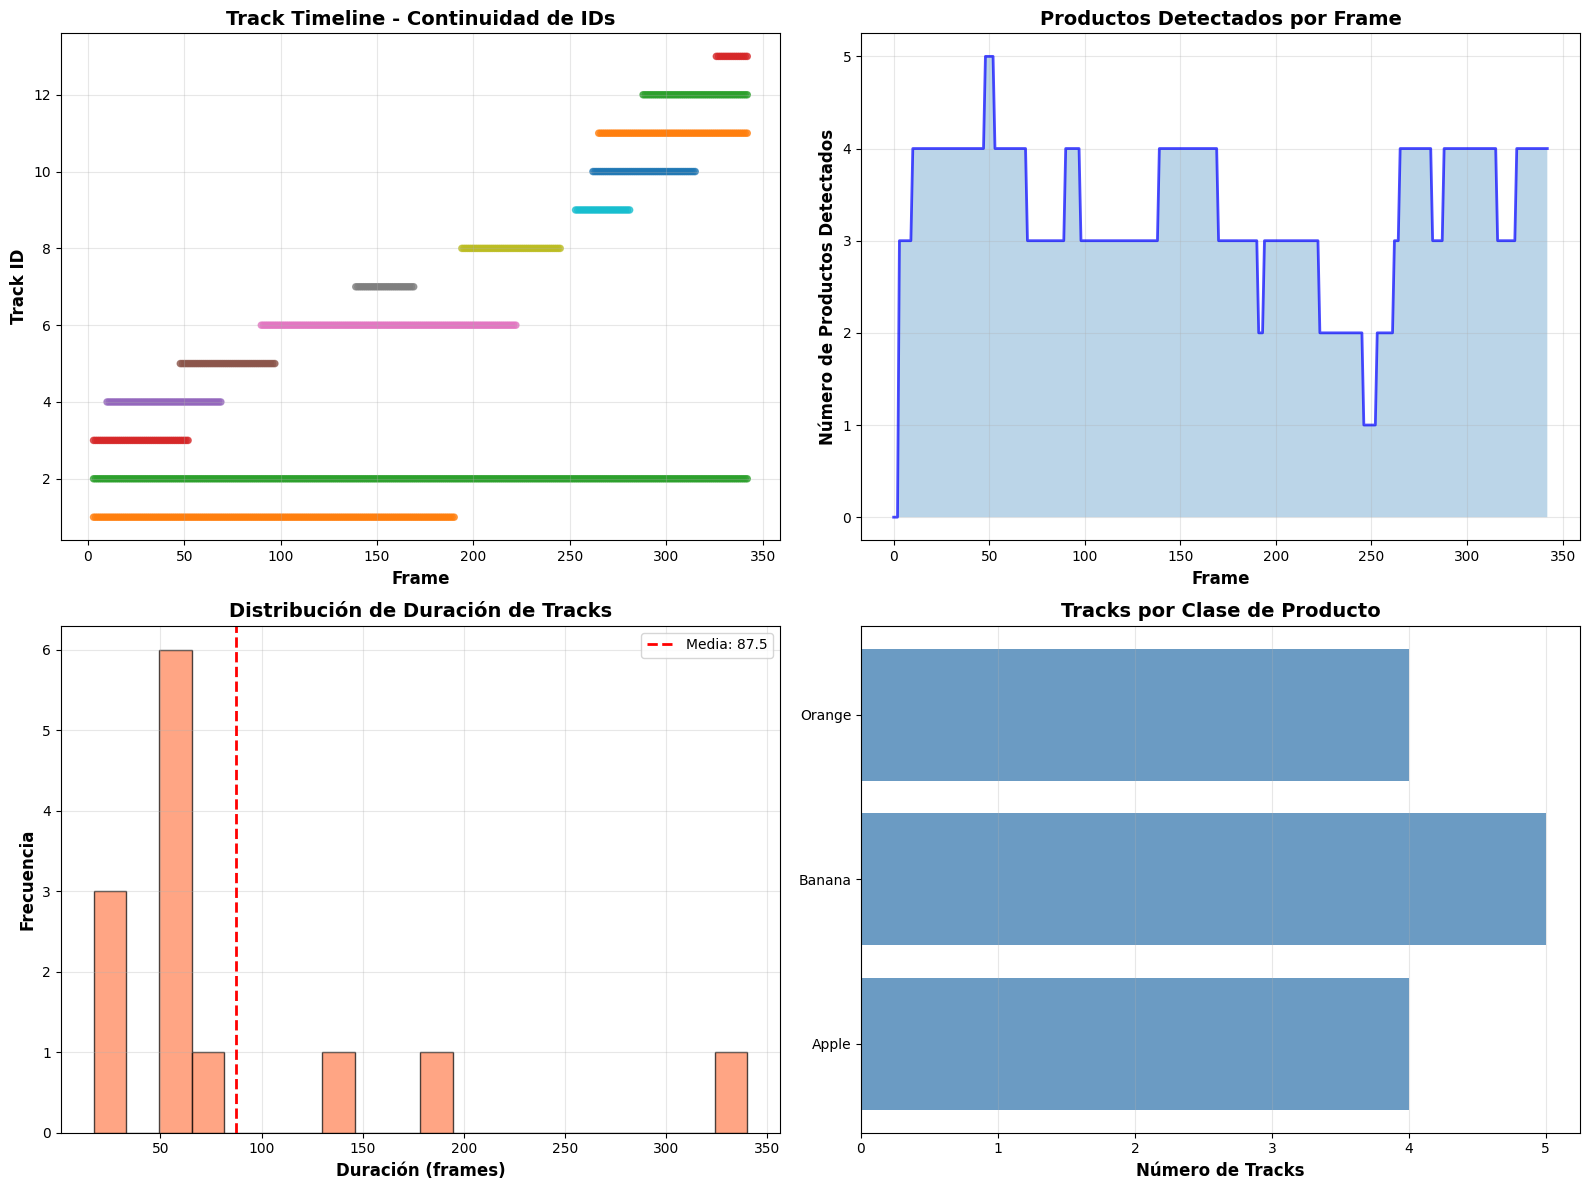


⚡ Métricas de calidad del tracking:
  Tracks cortos (<1s):  2 (15.4%)
  Tracks largos (>3s):  3 (23.1%)
  Tracks totales:       13


In [ ]:
# TODO: Analizar calidad del tracking

print("\n" + "=" * 70)
print("ESTADÍSTICAS DE TRACKING")
print("=" * 70)

if len(track_history) > 0:
    # Estadísticas generales
    all_durations = [len(track_info['frames']) for track_info in track_history.values()]
    avg_duration = np.mean(all_durations)
    max_duration = max(all_durations)
    min_duration = min(all_durations)

    print(f"\n📊 Estadísticas generales:")
    print(f"  Total productos trackeados: {len(track_history)}")
    print(f"  Duración promedio: {avg_duration:.1f} frames ({avg_duration/fps:.1f}s)")
    print(f"  Duración máxima: {max_duration} frames ({max_duration/fps:.1f}s)")
    print(f"  Duración mínima: {min_duration} frames ({min_duration/fps:.1f}s)")

    # Detalle por track
    print(f"\n📋 Detalle por producto trackeado:")
    print(f"{'Track ID':<12} {'Clase':<20} {'Duración':<15} {'Rango Frames':<20}")
    print("-" * 70)

    for track_id in sorted(track_history.keys()):
        track_info = track_history[track_id]
        frames = track_info['frames']
        class_name = track_info['class']
        duration = len(frames)
        start_frame = min(frames)
        end_frame = max(frames)

        print(f"Track {track_id:<6} {class_name:<20} {duration:>4} frames ({duration/fps:>4.1f}s) "
              f"{start_frame:>4} → {end_frame:<4}")

    # Tracks por clase
    class_track_counts = {}
    for track_info in track_history.values():
        class_name = track_info['class']
        class_track_counts[class_name] = class_track_counts.get(class_name, 0) + 1

    print(f"\n📦 Productos por clase:")
    for class_name, count in sorted(class_track_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {class_name:20s}: {count:3d} tracks")

    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Timeline de tracks
    ax1 = axes[0, 0]
    for track_id, track_info in track_history.items():
        frames = track_info['frames']
        class_name = track_info['class']
        ax1.scatter(frames, [track_id] * len(frames), s=20, alpha=0.7,
                   c=[plt.cm.tab10(track_id % 10)[:3]] * len(frames))
    ax1.set_xlabel('Frame', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Track ID', fontsize=12, fontweight='bold')
    ax1.set_title('Track Timeline - Continuidad de IDs', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    # 2. Detecciones por frame
    ax2 = axes[0, 1]
    ax2.plot(range(len(detections_per_frame)), detections_per_frame, 'b-', alpha=0.7, linewidth=2)
    ax2.fill_between(range(len(detections_per_frame)), detections_per_frame, alpha=0.3)
    ax2.set_xlabel('Frame', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Número de Productos Detectados', fontsize=12, fontweight='bold')
    ax2.set_title('Productos Detectados por Frame', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Distribución de duraciones
    ax3 = axes[1, 0]
    ax3.hist(all_durations, bins=20, color='coral', alpha=0.7, edgecolor='black')
    ax3.axvline(avg_duration, color='red', linestyle='--', linewidth=2, label=f'Media: {avg_duration:.1f}')
    ax3.set_xlabel('Duración (frames)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
    ax3.set_title('Distribución de Duración de Tracks', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Tracks por clase
    ax4 = axes[1, 1]
    classes = list(class_track_counts.keys())
    counts = list(class_track_counts.values())
    ax4.barh(classes, counts, color='steelblue', alpha=0.8)
    ax4.set_xlabel('Número de Tracks', fontsize=12, fontweight='bold')
    ax4.set_title('Tracks por Clase de Producto', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Métricas de calidad
    tracks_short = sum([1 for d in all_durations if d < fps])  # < 1 segundo
    tracks_long = sum([1 for d in all_durations if d > 3*fps])  # > 3 segundos

    print(f"\n⚡ Métricas de calidad del tracking:")
    print(f"  Tracks cortos (<1s):  {tracks_short} ({tracks_short/len(track_history)*100:.1f}%)")
    print(f"  Tracks largos (>3s):  {tracks_long} ({tracks_long/len(track_history)*100:.1f}%)")
    print(f"  Tracks totales:       {len(track_history)}")
else:
    print("⚠️ No se crearon tracks. Verifica el video y las detecciones.")

In [21]:
from ultralytics import YOLO
import torch
import os
import yaml
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Verificación de Entorno ---

# Asegurarnos de que el path a nuestro YAML esté definido
# (Debería estar en memoria de los pasos anteriores)
if 'yaml_path_str' not in locals() or not os.path.exists(yaml_path_str):
    print("⚠️ Recargando la variable 'yaml_path_str'...")
    # Re-definimos la ruta en caso de que el kernel se haya reiniciado
    dataset_root = Path('fruit_detection/Fruits-detection')
    yaml_path_str = str(dataset_root / 'data_fixed.yaml')

    if not os.path.exists(yaml_path_str):
        print("❌ ERROR: No se encuentra 'data_fixed.yaml'.")
        print("   Por favor, ejecuta el Paso 2.4 de nuevo para crearlo.")
    else:
        print(f"✅ 'yaml_path_str' cargado: {yaml_path_str}")
else:
    print(f"✅ 'yaml_path_str' ya está en memoria: {yaml_path_str}")

# --- 2. Definición del Experimento ---

# Definimos los modelos a comparar.
# Reemplazamos v11n por v5s para una comparación v5/v8 más rica.
models_to_compare = {
    'YOLOv5n': 'yolov5n.pt',
    'YOLOv5s': 'yolov5s.pt',  # Añadido para comparar
    'YOLOv8n': 'yolov8n.pt',  # Re-entrenamos para comparar (imgsz=416, fraction=0.25)
    'YOLOv8s': 'yolov8s.pt',
    'YOLOv8m': 'yolov8m.pt',
}

# Hiperparámetros fijos para una comparación justa
EPOCHS = 10
IMAGE_SIZE = 416
BATCH_SIZE = 16
FRACTION = 0.25
PROJECT_NAME = 'runs/detect_comparison'

print(f"\n=== 🧪 INICIANDO COMPARACIÓN DE ARQUITECTURAS ===")
print(f"   Modelos: {list(models_to_compare.keys())}")
print(f"   Epochs: {EPOCHS} | Image Size: {IMAGE_SIZE} | Batch Size: {BATCH_SIZE} | Fraction: {FRACTION}")
print("   ⏱️ Esto tomará un tiempo (aprox. 10-20 min por modelo)...")

# --- 3. Bucle de Entrenamiento ---

# Guardaremos los resultados de validación de cada modelo aquí
validation_results = {}
training_times = {}

for name, weights_file in models_to_compare.items():
    print(f"\n{'='*50}")
    print(f"🚀 Entrenando: {name} ({weights_file})")
    print(f"{'='*50}")

    # Cargar el modelo
    model = YOLO(weights_file)

    start_time = time.time()

    # Entrenar el modelo
    # Usamos 'name=name' para que cada corrida se guarde en su propia carpeta
    # (ej. runs/detect_comparison/YOLOv5n)
    train_results = model.train(
        data=yaml_path_str,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        fraction=FRACTION,
        project=PROJECT_NAME,
        name=name,
        patience=5,
        save=True,
        plots=True,
        device=0 if torch.cuda.is_available() else 'cpu',
        verbose=False # Ponlo en True si quieres ver el output de cada epoch
    )

    end_time = time.time()
    training_time_seconds = end_time - start_time
    training_times[name] = training_time_seconds

    print(f"✅ {name} completado en {training_time_seconds:.2f} segundos.")

    # --- 4. Validación y Recolección de Métricas ---
    # Usamos el 'best.pt' guardado para la validación final
    best_model_path = train_results.save_dir / 'weights' / 'best.pt'

    if os.path.exists(best_model_path):
        print(f"📦 Validando {name} desde {best_model_path}...")
        model_best = YOLO(best_model_path)

        # Medir tiempo de inferencia
        # 'val()' corre inferencia sobre el set de validación y mide el tiempo
        val_metrics = model_best.val(
            data=yaml_path_str,
            imgsz=IMAGE_SIZE,
            batch=BATCH_SIZE,
            split='val',
            plots=False,
            verbose=False
        )

        # Guardar las métricas clave
        validation_results[name] = {
            'mAP@0.5': val_metrics.box.map50,
            'mAP@0.5:0.95': val_metrics.box.map,
            'Precision': val_metrics.box.mp,
            'Recall': val_metrics.box.mr,
            'Inference Time (ms)': val_metrics.speed['inference'],
            'Model Size (MB)': os.path.getsize(best_model_path) / (1024 * 1024),
            'Training Time (s)': training_time_seconds,
            'mAP_by_class': val_metrics.box.maps  # mAP50 por clase
        }
        print(f"📊 {name} mAP@0.5: {val_metrics.box.map50:.4f}")

    else:
        print(f"❌ ERROR: No se encontró 'best.pt' para {name} en {best_model_path}")

print("\n\n✅✅✅ ¡COMPARACIÓN DE ENTRENAMIENTO COMPLETADA! ✅✅✅")

✅ 'yaml_path_str' ya está en memoria: fruit_detection/Fruits-detection/data_fixed.yaml

=== 🧪 INICIANDO COMPARACIÓN DE ARQUITECTURAS ===
   Modelos: ['YOLOv5n', 'YOLOv5s', 'YOLOv8n', 'YOLOv8s', 'YOLOv8m']
   Epochs: 10 | Image Size: 416 | Batch Size: 16 | Fraction: 0.25
   ⏱️ Esto tomará un tiempo (aprox. 10-20 min por modelo)...

🚀 Entrenando: YOLOv5n (yolov5n.pt)
PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruit_detection/Fru

✅ Gráfico de trade-off guardado en: speed_vs_accuracy_tradeoff.png


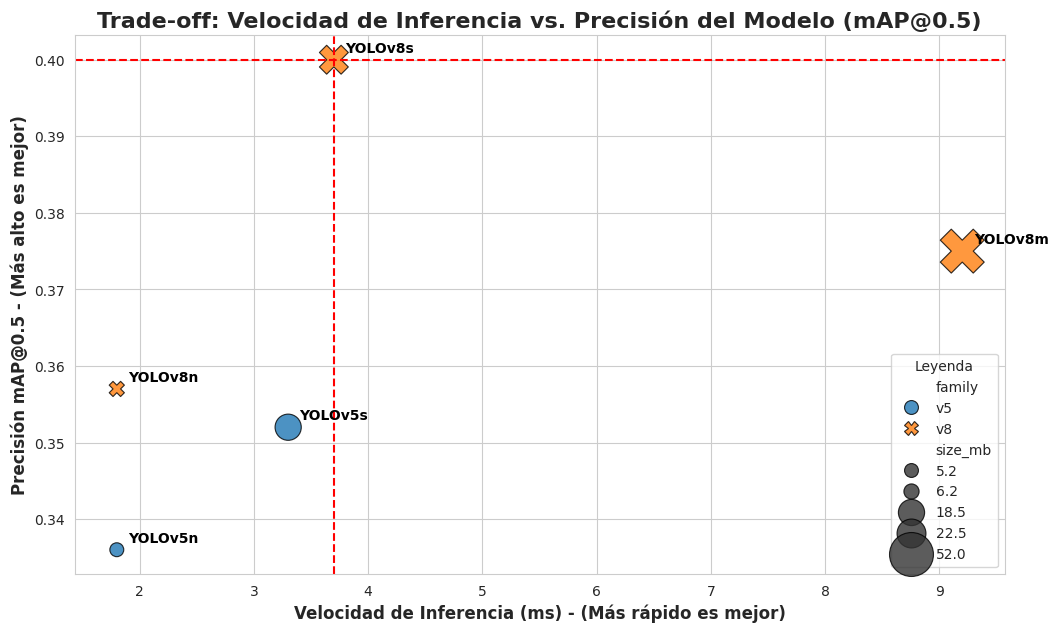

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Crear el DataFrame con los datos que extrajimos de tu log
data = {
    'model': ['YOLOv5n', 'YOLOv5s', 'YOLOv8n', 'YOLOv8s', 'YOLOv8m'],
    'family': ['v5', 'v5', 'v8', 'v8', 'v8'],
    'mAP@0.5': [0.336, 0.352, 0.357, 0.400, 0.375],
    'inference_ms': [1.8, 3.3, 1.8, 3.7, 9.2],
    'size_mb': [5.2, 18.5, 6.2, 22.5, 52.0]
}
df_results = pd.DataFrame(data)

# 2. Crear el Gráfico de Velocidad vs. Precisión
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Usamos un scatterplot
# x = Velocidad (mientras más a la izquierda, mejor)
# y = Precisión (mientras más arriba, mejor)
# size = Tamaño del modelo (burbuja más grande = modelo más pesado)
# hue = Familia (v5 vs v8)
plot = sns.scatterplot(
    data=df_results,
    x='inference_ms',
    y='mAP@0.5',
    size='size_mb',
    hue='family',
    sizes=(100, 1000),  # Rango de tamaño de las burbujas
    style='family',
    s=100,
    alpha=0.8,
    edgecolor='black'
)

# 3. Anotar cada punto con el nombre del modelo
for i in range(df_results.shape[0]):
    plt.text(
        x=df_results.inference_ms[i] + 0.1,  # Ligeramente a la derecha del punto
        y=df_results['mAP@0.5'][i] + 0.001, # Ligeramente arriba del punto
        s=df_results.model[i],
        fontdict=dict(color='black', size=10, weight='bold')
    )

# 4. Configurar títulos y etiquetas
plt.title('Trade-off: Velocidad de Inferencia vs. Precisión del Modelo (mAP@0.5)', fontsize=16, weight='bold')
plt.xlabel('Velocidad de Inferencia (ms) - (Más rápido es mejor)', fontsize=12, weight='bold')
plt.ylabel('Precisión mAP@0.5 - (Más alto es mejor)', fontsize=12, weight='bold')
plt.legend(title='Leyenda', loc='lower right')
plt.axvline(x=3.7, color='r', linestyle='--', label='YOLOv8s (Mejor Precisión)')
plt.axhline(y=0.400, color='r', linestyle='--', label='YOLOv8s (Mejor Precisión)')

# Guardar la imagen
speed_accuracy_plot_path = 'speed_vs_accuracy_tradeoff.png'
plt.savefig(speed_accuracy_plot_path)

print(f"✅ Gráfico de trade-off guardado en: {speed_accuracy_plot_path}")
plt.show()